In [1]:
import random
from dro import OnlineDRO
import numpy as np
import matplotlib.pyplot as plt
import collections as col
import math


In [2]:
class DiscountedAverage:
    def __init__(self, tau):
        self.tau = tau
        self.sumr = 0
        self.n = 0
    
    def update(self, r):
        self.sumr = self.tau * self.sumr + r
        self.n = self.tau * self.n + 1
    
    def current(self):
        if self.n == 0:
            return 0
        return self.sumr / self.n


class MovingAverage:
    def __init__(self, size):
        self.samples = col.deque()
        self.size = size
    
    def update(self, r):
        self.samples.append(r)
        if len(self.samples) > self.size:
            self.samples.popleft()
    
    def current(self):
        if len(self.samples) == 0:
            return 0
        return sum(self.samples) / len(self.samples)

def gen_pmf(actions, epsilon, exploit_idx):
    pmf = [epsilon / actions] * actions
    pmf[exploit_idx] += 1 - epsilon
    return pmf

def sample_custom_pmf(pmf, rng):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = rng.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index
    raise Exception("can't sample")

In [3]:

def run_2(policy, eval, get_reward, count, tau, rng):
    m_size = int(1 / (1 - tau)) + 1

    ci = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau=tau)
    avg = DiscountedAverage(tau=tau)
    avg2 = MovingAverage(size=m_size)
    w_avg = DiscountedAverage(tau=tau)
    w_avg2 = MovingAverage(size=m_size)

    avg_lst = []
    avg2_lst = []
    w_avg_lst = []
    w_avg2_lst = []
    lb_lst = []
    for i in range(count):
       p_action = sample_custom_pmf(policy,rng)
       e_action = sample_custom_pmf(eval, rng)
       reward = get_reward(i, p_action)

       w = 1 / policy[p_action]
       if p_action != e_action:
           w = 0
       ci.update(c=1, w=w, r=reward)
       avg.update(reward)
       avg2.update(reward)
       w_avg.update(w)
       w_avg2.update(w)
       ci.recomputeduals()

       avg_lst.append(avg.current())
       avg2_lst.append(avg2.current())
       w_avg_lst.append(w_avg.current())
       w_avg2_lst.append(w_avg2.current())
       lb_lst.append(ci.duals[0][0])
    return (lb_lst, avg_lst, avg2_lst, w_avg_lst, w_avg2_lst)

def switch_midpoint(idx, action, limit, p0, p1):
    if idx < limit:
        return p0[action]
    return p1[action]



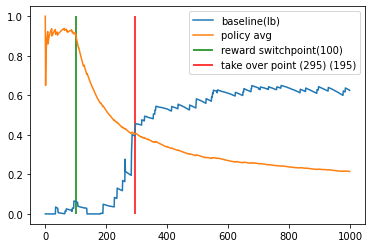

In [4]:

policy = gen_pmf(4, 0.2, 3)
baseline = gen_pmf(4, 0.2, 0)

p0_reward = [0.1, 0.3, 0.3, 1]
p1_reward = [1, 0.3, 0.3, 0.1]

def plot_stuff(tau, count, switch_point, rng=None):
    gr = lambda i,a : switch_midpoint(i, a, switch_point, p0_reward, p1_reward)
    res = run_2(policy, baseline, gr, count, tau, rng)
    idx = switch_point + 1
    while idx < len(res[0]) and res[0][idx] < res[1][idx]:
        idx += 1


    plt.plot(res[0], label=f'baseline(lb)')
    plt.plot(res[1], label=f'policy avg')
    plt.vlines(x=switch_point, ymin=0, ymax=1, label=f'reward switchpoint({switch_point})', color='green')
    plt.vlines(x=idx, ymin=0, ymax=1, label=f'take over point ({idx}) ({idx - switch_point})', color='red')



# plt.figure(figsize=(8, 6))
plot_stuff(0.999, 1000, 100, np.random.default_rng(37))
plt.legend()


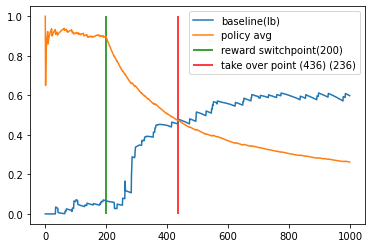

In [5]:
plot_stuff(0.999, 1000, 200, np.random.default_rng(37))
plt.legend()


switchpoint at 283
switchpoint at 747


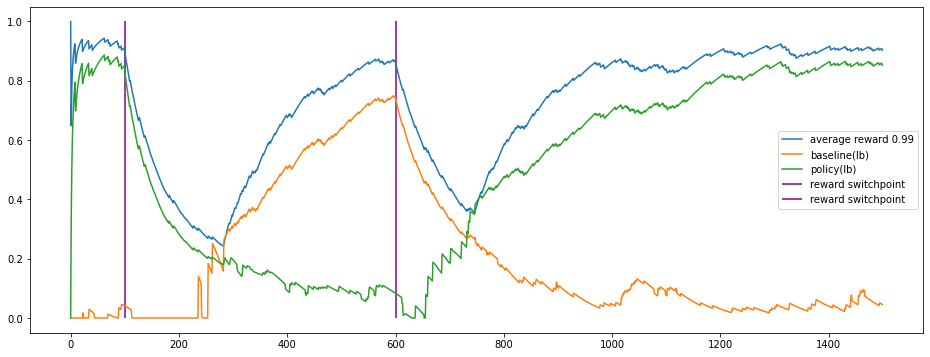

In [6]:
def run_3(policy, baseline, get_reward, policy_update, count, tau, rng, initial_policy):
    m_size = int(1 / (1 - tau)) + 1

    ci_base = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau=tau)
    ci_policy = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau=tau)
    avg = DiscountedAverage(tau=tau)

    avg_lst = []
    base_lb_lst = []
    policy_lb_lst = []

    current_policy = initial_policy
    for i in range(count):
       policy_action = sample_custom_pmf(policy,rng)
       baseline_action = sample_custom_pmf(baseline, rng)

       eff_action = policy_action
       eff_prob = policy[policy_action]

       if current_policy == 1:
           eff_action = baseline_action
           eff_prob = baseline[baseline_action]

       reward = get_reward(i, eff_action)
       w = 1 / eff_prob
       if baseline_action != policy_action:
           w = 0

       if current_policy == 0: #playing policy
           ci_base.update(c=1, w=w, r=reward)
           ci_policy.update(c=1, w=1, r=reward)
       else:
           ci_base.update(c=1, w=1, r=reward)
           ci_policy.update(c=1, w=w, r=reward)

       avg.update(reward)
       ci_base.recomputeduals()
       ci_policy.recomputeduals()
       current_policy = policy_update(i, current_policy, avg.current(), ci_base.duals[0][0], ci_policy.duals[0][0])

       avg_lst.append(avg.current())
       base_lb_lst.append(ci_base.duals[0][0])
       policy_lb_lst.append(ci_policy.duals[0][0])

    return (avg_lst, base_lb_lst, policy_lb_lst)



policy = gen_pmf(4, 0.2, 3)
baseline = gen_pmf(4, 0.2, 0)

p0_reward = [0.1, 0.3, 0.3, 1]
p1_reward = [1, 0.3, 0.3, 0.1]


def switch_list(idx, action, r_list):
    for p in r_list:
        if idx < p[0]:
            return p[1][action]
    return r_list[len(r_list)-1][1][action]

def policy_update(i, cur, avg, base_lb, policy_lb):
    p_val = base_lb
    alt_p = 1
    if cur == 1:
        p_val = policy_lb
        alt_p = 0
    
    if p_val > avg:
        print(f'switchpoint at {i}')
        return alt_p
    return cur
dists = [(100, p0_reward), (600, p1_reward), (10000, p0_reward)]

def plot_stuff2(tau, count, rng=None):

    gr = lambda i,a : switch_list(i, a, dists)
    pol_up = policy_update

    res = run_3(policy, baseline, gr, pol_up, count, tau, rng, 0)

    plt.plot(res[0], label=f'average reward {tau}')
    plt.plot(res[1], label=f'baseline(lb)')
    plt.plot(res[2], label=f'policy(lb)')


plt.figure(figsize=(16,6))
# plot_stuff2(0.9999, 2000, np.random.default_rng(37))
# plot_stuff2(0.999, 1500, np.random.default_rng(37))
plot_stuff2(0.99, 1500, np.random.default_rng(37))

plt.vlines(x=dists[0][0], ymin=0, ymax=1, label=f'reward switchpoint', color='purple')
plt.vlines(x=dists[1][0], ymin=0, ymax=1, label=f'reward switchpoint', color='purple')

plt.legend()

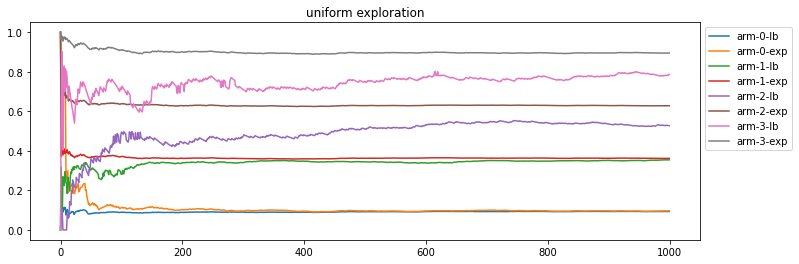

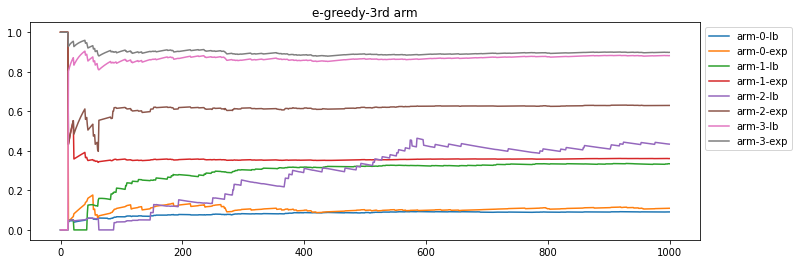

In [40]:
# let's try a scenario identical to VW:
# 1. a stochastic policy generates (a, p, r) tuples
# we build per-arm CIs. This is equivalent to evaluating vs baseline and vs a policy that learns the best arm


class Expectation:
    def __init__(self, tau):
        self.tau = tau
        self.sum = 0
        self.n = 0

    def update(self, w, r):
        self.sum = self.tau * self.sum + w * r
        self.n = self.tau * self.n + w

    def current(self):
        if self.n == 0:
            return 0
        return self.sum / self.n

class Arm:
    def __init__(self, tau, actions, arm):
        self.ci = OnlineDRO.OnlineCressieReadLB(alpha=0.05, tau = tau)
        self.exp = Expectation(tau)
        self.pmf = gen_pmf(actions, 0.2, arm)
        self.arm = arm
        self.data = []
        self.data2 = []

    def update(self, a, p, r, rng):
        w = self.pmf[a] / p

        self.ci.update(c=1, w=w, r=r)
        self.ci.recomputeduals()
        self.data.append(self.ci.duals[0][0])

        self.exp.update(w, r)
        self.data2.append(self.exp.current())

    def plot(self):
        plt.plot(self.data, label=f'arm-{self.arm}-lb')
        plt.plot(self.data2, label=f'arm-{self.arm}-exp')


def run_and_plot_stuff(title, actions, count, pmf, reward):
    rng = np.random.default_rng(101)
    arms = []
    for i in range(actions):
        arms.append(Arm(0.9999, actions, i))

    for i in range(count):
        a = sample_custom_pmf(pmf, rng)
        p = pmf[a]
        r = reward[a]
        for arm in arms:
            arm.update(a, p, r, rng)

    plt.figure(figsize=(12,4))
    plt.title(title)
    for arm in arms:
        arm.plot()
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.show()

run_and_plot_stuff("uniform exploration", 4, 1000, [1.0 / 4 ] * 4, np.linspace(0, 1, 4))
run_and_plot_stuff("e-greedy-3rd arm", 4, 1000, gen_pmf(4, 0.2, 3), np.linspace(0, 1, 4))